# Classification Methods
---
 - Logistic Regression
 - Discriminant Analysis: LDA/QDA/Naive Bayes
 - K-Nearest Neighbors
 - Decision Trees
 - Random Forests
 - Support Vector Machines

In [1]:
import io
import time
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

## 0 Data

In [2]:
url = "https://raw.githubusercontent.com/katkatrina-K/Machine-Learning-Study/main/Data/weekly.csv"
s = requests.get(url).content
Weekly = pd.read_csv(io.StringIO(s.decode('utf-8')))
Weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


 - Direction: A factor with levels Down and Up indicating whether the market had a positive or negative return on a given week
- Year: The year that the observation was recorded  
 - Lag1: Percentage return for previous week  
 - Lag2: Percentage return for 2 weeks previous  
 - Lag3: Percentage return for 3 weeks previous  
 - Lag4: Percentage return for 4 weeks previous  
 - Lag5: Percentage return for 5 weeks previous  
 - Volume: Volume of shares traded (average number of daily shares traded in billions)
 - Today: Percentage return for this week  

#### Data Inspection

In [3]:
Weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


#### Pairwise Correlations

Text(0.5, 1.0, 'Correlation Heatmap')

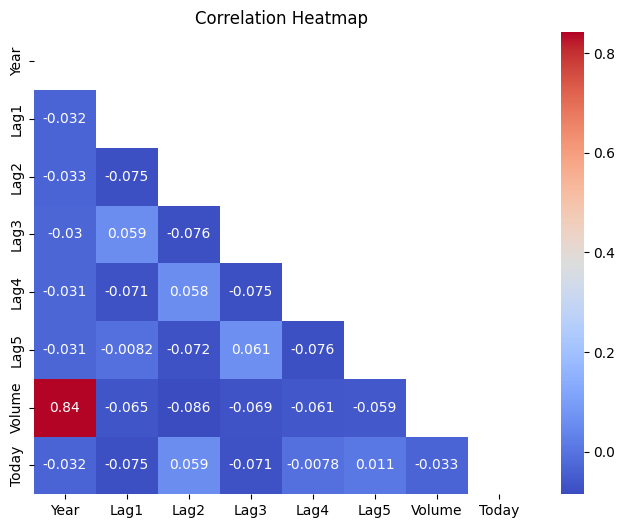

In [4]:
corr = Weekly.corr()
plt.figure(figsize = (8,6))
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot = True, cmap = 'coolwarm', mask = mask)
plt.title('Correlation Heatmap')

The correlation coefficients between variables reveal that almost all variables are not correlated with each other, except for year and volume.

Text(0.5, 1.0, 'Weekly Volume from 1990 to 2010')

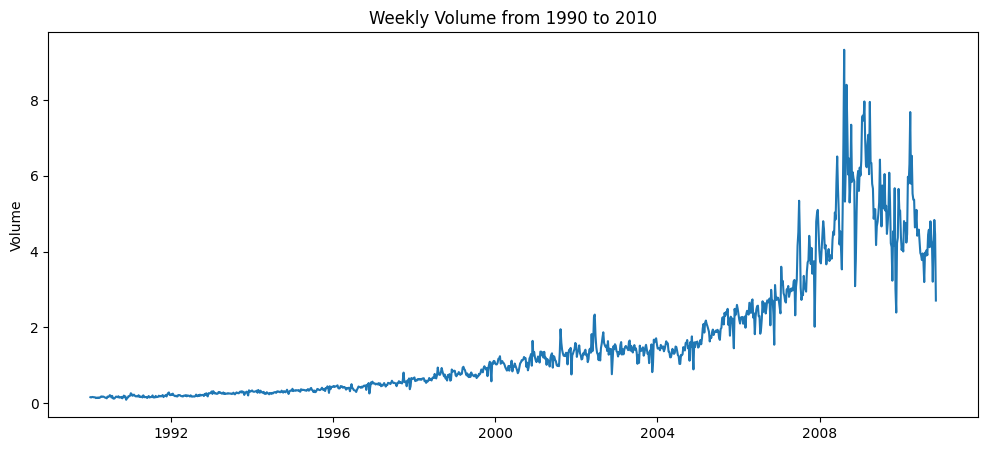

In [5]:
start_date = '1990-01-01'
date_range = pd.date_range(start_date, periods = 1089, freq = 'W')
plt.figure(figsize = (12,5))
sns.lineplot(x = date_range, y = Weekly.Volume)
plt.title('Weekly Volume from 1990 to 2010')

#### Data Balance Problems

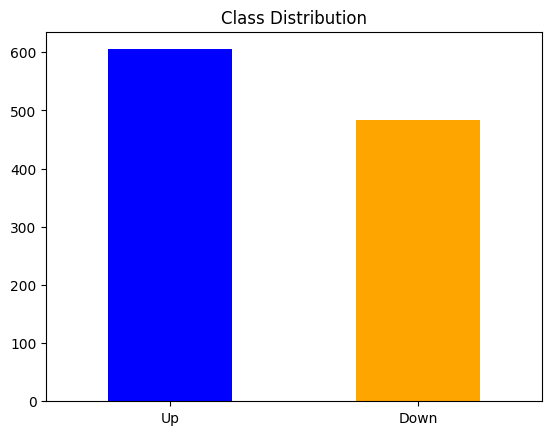

In [6]:
class_counts = Weekly.Direction.value_counts()
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.xticks(rotation = 0)
plt.title('Class Distribution')
plt.show()

It looks like the data is relatively balanced.

#### Preprocessing

In [7]:
seed = 45

In [8]:
# Split data into 80/20 in out of sample
Weekly['Direction'] = Weekly['Direction'].apply(lambda x: 1 if x == 'Up' else 0)
train_size = int(0.8 * len(Weekly))
Weekly_train = Weekly[:train_size]
Weekly_test = Weekly[train_size:]
print('Train Sets: ', Weekly_train.shape)
print('Test Sets: ', Weekly_test.shape)

Train Sets:  (871, 9)
Test Sets:  (218, 9)


In [9]:
# Split X and y
X_train = Weekly_train.drop(['Direction', 'Today', 'Year'], axis = 1)
y_train = Weekly_train.Direction
X_test = Weekly_test.drop(['Direction', 'Today', 'Year'], axis = 1)
y_test = Weekly_test.Direction

In [10]:
# Preprocessing
num_features = X_train.columns

num_tf = Pipeline(steps = [('scaler', StandardScaler())])
col_tf = ColumnTransformer(transformers = [('num', num_tf, num_features)])

## 1 Baseline Model

In [11]:
most_frequent_class = y_train.mode()[0]
y_pred_baseline = [most_frequent_class] * len(y_test)
test_acc_baseline = accuracy_score(y_test, y_pred_baseline)
test_auc_baseline = np.NaN
print(f'test Accuracy: {test_acc_baseline:.4f}',',', f'test roc_auc: {test_auc_baseline:.4f}')

test Accuracy: 0.5413 , test roc_auc: nan


## 2 Logistic Regression

#### Model

In [12]:
mod_log = LogisticRegression(solver = 'liblinear', max_iter = 10000, random_state = seed)
pip_log = Pipeline(steps = [('col_tf', col_tf), ('model', mod_log)])

#### Tuning Grid

In [13]:
# Tuning Parameter: penalty, C
penalty_log = ['l1', 'l2']
C_log = np.logspace(start = - 5, stop = 2, num = 20)
param_log = {'model__penalty': penalty_log,
             'model__C': C_log}

# Cross-Validation
search_log = GridSearchCV(pip_log, param_log, cv = TimeSeriesSplit(10), scoring = 'accuracy')
tic = time.time()
search_log.fit(X_train, y_train)
toc = time.time()
print('Execution time:', toc-tic, 'seconds')

# CV Results
cv_log = pd.DataFrame({'Penalty': search_log.cv_results_['param_model__penalty'],
                       'C': search_log.cv_results_['param_model__C'],
                       'Accuracy': search_log.cv_results_['mean_test_score']})
cv_log

Execution time: 1.6798701286315918 seconds


,Penalty,C,Accuracy
0,l1,0.00001,0.440506
1,l2,0.00001,0.551899
2,l1,0.000023,0.440506
3,l2,0.000023,0.551899
4,l1,0.000055,0.440506
5,l2,0.000055,0.551899
6,l1,0.000127,0.440506
7,l2,0.000127,0.551899
8,l1,0.000298,0.440506
9,l2,0.000298,0.550633


<Figure size 800x500 with 0 Axes>

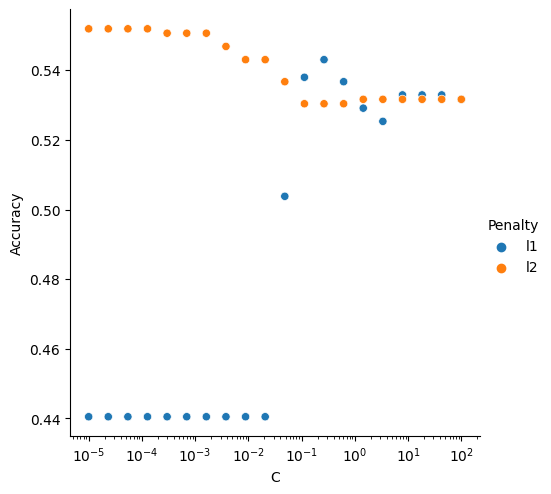

In [14]:
# CV Results Visualization
plt.figure(figsize = (8,5))
sns.relplot(data = cv_log, x = 'C', y = 'Accuracy', hue = 'Penalty').set(
    xlabel = 'C', ylabel = 'Accuracy', xscale = 'log' )
plt.show()

In [15]:
search_log.best_estimator_

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume'], dtype='object'))])),
                ('model',
                 LogisticRegression(C=1e-05, max_iter=10000, random_state=45,
                                    solver='liblinear'))])

#### Evaluation

In [ ]:
y_pred_log = search_log.best_estimator_.predict(X_test)
test_acc_log = accuracy_score(y_test, y_pred_log)
test_auc_log = roc_auc_score(y_test, y_pred_log)
cv_acc_log = search_log.best_score_
print(f'CV Accuracy: {cv_acc_log:.4f}')
print(f'test Accuracy: {test_acc_log:.4f}',',', f'test roc_auc: {test_auc_log:.4f}')

## 3 Discriminant Analysis

### 3.1 Linear Discriminant Analysis 

#### Model

In [ ]:
mod_lda = LinearDiscriminantAnalysis()
pip_lda = Pipeline(steps = [('col_tf', col_tf), ('model', mod_lda)])
pip_lda.fit(X_train, y_train)

#### Evaluation

In [ ]:
y_pred_lda = pip_lda.predict(X_test)
test_acc_lda = accuracy_score(y_test, y_pred_lda)
test_auc_lda = roc_auc_score(y_test, y_pred_lda)
print(f'test Accuracy: {test_acc_lda:.4f}',',', f'test roc_auc: {test_auc_lda:.4f}')

### 3.2 Quadratic Discriminant Analysis


#### Model

In [ ]:
mod_qda = QuadraticDiscriminantAnalysis()
pip_qda = Pipeline(steps = [('col_tf', col_tf), ('model', mod_qda)])
pip_qda.fit(X_train, y_train)

#### Evaluation

In [ ]:
y_pred_qda = pip_qda.predict(X_test)
test_acc_qda = accuracy_score(y_test, y_pred_qda)
test_auc_qda = roc_auc_score(y_test, y_pred_qda)
print(f'test Accuracy: {test_acc_qda:.4f}',',', f'test roc_auc: {test_auc_qda:.4f}')

### 3.3 Naive Bayes Classifier

#### Model

In [ ]:
mod_nb = GaussianNB()
pip_nb = Pipeline(steps = [('col_tf', col_tf), ('model', mod_nb)])
pip_nb.fit(X_train, y_train)

#### Evaluation

In [ ]:
y_pred_nb = pip_nb.predict(X_test)
test_acc_nb = accuracy_score(y_test, y_pred_nb)
test_auc_nb = roc_auc_score(y_test, y_pred_nb)
print(f'test Accuracy: {test_acc_nb:.4f}',',', f'test roc_auc: {test_auc_nb:.4f}')

## 4 K-Nearest Neighbors Classifier

#### Model

In [ ]:
mod_knn = KNeighborsClassifier(n_neighbors = 5)
pip_knn = Pipeline(steps = [('col_tf', col_tf), ('model', mod_knn)])

#### Tuning Grid

In [ ]:
# Tuning Parameter: n_neighbors
n_knn = np.arange(3,30)
param_knn = {'model__n_neighbors': n_knn}

# Cross-Validation
search_knn = GridSearchCV(pip_knn, param_knn, cv = TimeSeriesSplit(10), scoring = 'accuracy')
tic = time.time()
search_knn.fit(X_train, y_train)
toc = time.time()
print('Execution time:', toc-tic, 'seconds')

# CV Results
cv_knn = pd.DataFrame({'n_neighbours': search_knn.cv_results_['param_model__n_neighbors'],
                       'Accuracy': search_knn.cv_results_['mean_test_score']})
cv_knn

In [ ]:
# CV Results Visualization
plt.figure(figsize = (8,5))
sns.relplot(data = cv_knn, x = 'n_neighbours', y = 'Accuracy').set(
    xlabel = 'n_neighbours', ylabel = 'Accuracy' )
plt.show()

In [ ]:
search_knn.best_estimator_

#### Evaluation

In [ ]:
y_pred_knn = search_knn.best_estimator_.predict(X_test)
test_acc_knn = accuracy_score(y_test, y_pred_knn)
test_auc_knn = roc_auc_score(y_test, y_pred_knn)
cv_acc_knn = search_knn.best_score_
print(f'CV Accuracy: {cv_acc_knn:.4f}')
print(f'test Accuracy: {test_acc_knn:.4f}',',', f'test roc_auc: {test_auc_knn:.4f}')

## 5 Decision Trees

#### Model

In [ ]:
mod_tree = DecisionTreeClassifier(criterion = 'gini', random_state = seed)
pip_tree = Pipeline(steps = [('col_tf', col_tf), ('model', mod_tree)])

#### Tuning Grid

In [ ]:
# Tuning Parameter: ccp_alpha
ccp_alpha_tree = np.linspace(start = 0.0, stop = 0.03, num = 100)
param_tree = {'model__ccp_alpha': ccp_alpha_tree}

# Cross-Validation
search_tree = GridSearchCV(pip_tree, param_tree, cv = TimeSeriesSplit(10), scoring = 'accuracy', refit = True)
tic = time.time()
search_tree.fit(X_train, y_train)
toc = time.time()
print('Execution time:', toc-tic, 'seconds')

# CV Results
cv_tree = pd.DataFrame({'ccp_alpha': search_tree.cv_results_['param_model__ccp_alpha'],
                       'Accuracy': search_tree.cv_results_['mean_test_score']})
cv_tree

In [ ]:
# CV Results Visualization
plt.figure(figsize = (8,5))
sns.relplot(data = cv_tree, x = 'ccp_alpha', y = 'Accuracy').set(
    xlabel = 'ccp_alpha', ylabel = 'Accuracy' )
plt.show()

In [ ]:
search_tree.best_estimator_

#### Evaluation

In [ ]:
y_pred_tree = search_tree.predict(X_test)
test_acc_tree = accuracy_score(y_test, y_pred_tree)
test_auc_tree = roc_auc_score(y_test, y_pred_tree)
cv_acc_tree = search_tree.best_score_
print(f'CV Accuracy: {cv_acc_tree:.4f}')
print(f'test Accuracy: {test_acc_tree:.4f}',',', f'test roc_auc: {test_auc_tree:.4f}')

## 6 Random Forests

#### Model

In [ ]:
mod_rf = RandomForestClassifier(n_estimators = 100, criterion = 'gini',
                                max_features = 'sqrt', oob_score = True,
                                random_state = seed)
pip_rf = Pipeline(steps = [('col_tf', col_tf), ('model', mod_rf)])

#### Tuning Grid

In [ ]:
# Tuning Parameter: n_estimators, max_features
n_estimators_rf = [50, 100, 150, 200, 250, 300]
max_features_rf = ['sqrt', 'log2', 1.0]
param_rf = {'model__n_estimators': n_estimators_rf,
              'model__max_features': max_features_rf}

# Cross-Validation
search_rf = GridSearchCV(pip_rf, param_rf, cv = TimeSeriesSplit(10), scoring = 'accuracy', refit = True)
tic = time.time()
search_rf.fit(X_train, y_train)
toc = time.time()
print('Execution time:', toc-tic, 'seconds')

# CV Results
cv_rf = pd.DataFrame({'n_estimators': search_rf.cv_results_['param_model__n_estimators'],
                      'max_features': search_rf.cv_results_['param_model__max_features'],
                      'Accuracy': search_rf.cv_results_['mean_test_score']})
cv_rf

In [ ]:
# CV Results Visualization
plt.figure(figsize = (8,5))
sns.relplot(data = cv_rf, x = 'n_estimators', y = 'Accuracy', hue = 'max_features').set(
    xlabel = 'n_estimators', ylabel = 'Accuracy' )
plt.show()

In [ ]:
search_rf.best_estimator_

#### Evaluation

In [ ]:
y_pred_rf = search_rf.predict(X_test)
test_acc_rf = accuracy_score(y_test, y_pred_rf)
test_auc_rf = roc_auc_score(y_test, y_pred_rf)
cv_acc_rf = search_tree.best_score_
print(f'CV Accuracy: {cv_acc_rf:.4f}')
print(f'test Accuracy: {test_acc_rf:.4f}',',', f'test roc_auc: {test_auc_rf:.4f}')

## 7 Support Vector Machines

#### Model

In [ ]:
mod_svm = SVC(random_state = seed)
pip_svm = Pipeline(steps = [('col_tf', col_tf), ('model', mod_svm)])

#### Tuning Grid

In [ ]:
# Tuning Parameter: C, kernel
C_svm = np.logspace(start = - 3, stop = 2, num = 20)
kernel_svm = ['poly', 'rbf']
degree_svm = [2, 3, 4, 5]
gamma_svm = ['scale', 'auto']
param_svm = {'model__C': C_svm,
             'model__kernel': kernel_svm,
             'model__degree': degree_svm,
             'model__gamma': gamma_svm}

# Cross-Validation
search_svm = GridSearchCV(pip_svm, param_svm, cv = TimeSeriesSplit(10), scoring = 'accuracy', refit = True)
tic = time.time()
search_svm.fit(X_train, y_train)
toc = time.time()
print('Execution time:', toc-tic, 'seconds')

# CV Results
cv_svm = pd.DataFrame({'C': search_svm.cv_results_['param_model__C'],
                       'kernel': search_svm.cv_results_['param_model__kernel'],
                       'degree': search_svm.cv_results_['param_model__degree'],
                       'gamma': search_svm.cv_results_['param_model__gamma'],
                       'Accuracy': search_svm.cv_results_['mean_test_score']})
cv_svm

In [ ]:
# CV Results Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for kernel = 'poly'
cv_svm_poly = cv_svm[cv_svm['kernel'] == 'poly']
for degree in sorted(cv_svm_poly['degree'].unique()):
    cv_svm_poly_degree = cv_svm_poly[cv_svm_poly['degree'] == degree]
    axes[0].scatter(cv_svm_poly_degree['C'], cv_svm_poly_degree['Accuracy'], label=f'Degree {degree}')
axes[0].set_xscale('log')
axes[0].set_xlabel('C')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('SVM with Polynomial Kernel')
axes[0].legend()

# Plot for kernel = 'rbf'
cv_svm_rbf = cv_svm[cv_svm['kernel'] == 'rbf']
for gamma in sorted(cv_svm_rbf['gamma'].unique()):
    cv_svm_rbf_gamma = cv_svm_rbf[cv_svm_rbf['gamma'] == gamma]
    axes[1].scatter(cv_svm_rbf_gamma['C'], cv_svm_rbf_gamma['Accuracy'], label=f'Gamma {gamma}')
axes[1].set_xscale('log')
axes[1].set_xlabel('C')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('SVM with RBF Kernel')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
search_svm.best_estimator_

#### Evaluation

In [ ]:
y_pred_svm = search_svm.predict(X_test)
test_acc_svm = accuracy_score(y_test, y_pred_svm)
test_auc_svm = roc_auc_score(y_test, y_pred_svm)
cv_acc_svm = search_svm.best_score_
print(f'CV Accuracy: {cv_acc_svm:.4f}')
print(f'test Accuracy: {test_acc_svm:.4f}',',', f'test roc_auc: {test_auc_svm:.4f}')

## 8 Summary

In [ ]:
methods = {'Baseline Model': [test_acc_baseline, test_auc_baseline],
           'Logistic Regression': [test_acc_log, test_auc_log],
           'LDA': [test_acc_lda, test_auc_lda],
           'QDA': [test_acc_qda, test_auc_qda],
           'Naive Bayes': [test_acc_nb, test_auc_nb],
           'K-Nearest Neighbors': [test_acc_knn, test_auc_knn],
           'Decision Trees': [test_acc_tree, test_auc_tree],
           'Random Forests': [test_acc_rf, test_auc_rf],
           'Support Vector Machines': [test_acc_svm, test_auc_svm]}
summary = pd.DataFrame.from_dict(methods, orient='index', columns=['test Accuracy', 'test roc_auc'])
summary

In [ ]:
max_acc_method = summary['test Accuracy'].idxmax()
max_auc_method = summary['test roc_auc'].idxmax()
print("Method with the highest test accuracy: ", max_acc_method)
print("Method with the highest test roc_auc: ", max_auc_method)